In [91]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import scipy.misc 
%matplotlib inline
from scipy.misc import imresize
from six.moves import cPickle

In [2]:
# load motifs
motiflist = 'motif.pickle'  
if os.path.isfile(motiflist):

    # load motif list from file
    f = open(motiflist, 'rb')
    motif_set = cPickle.load(f)
    f.close()

else:
    # download motifs
    motifpath = 'top10align_motifs/'   # directory where motif files are located

    # get all motif files in motifpath directory
    listdir = os.listdir(motifpath)

    # parse motifs
    motif_set = []
    for files in listdir:
        df = pd.read_table(os.path.join(motifpath,files))
        motif_set.append(df.iloc[0::,1::].transpose())

    # save motifs    
    f = open(motiflist, 'wb')
    cPickle.dump(motif_set, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

# Simple dataset

In [117]:
def generate_grammar_model(options):
    """generate a regulatory grammar model: various numbers of motifs with 
    distinct separations."""

    # input options
    motif_set = options[0]   # set of all motifs
    num_motif = options[1]           # number of motifs for data set (to sample from motif_set)
    num_grammar = options[2]           # number of regulatory grammars (combinations of motifs)
    interaction_rate = options[3]  # exponential rate of number of motifs for each grammar
    distance_scale = options[4]    # exponential rate of distance between motifs
    distance_offset = options[5]   # offset addition between motif distances
    max_motif = options[6]         # maximum number of motifs in a grammar

    # select M random motifs from the complete list of motif_set
    motifIndex = np.random.permutation(len(motif_set))[0:num_motif]

    # build subset of motifs relevant for dataset
    motifs = []
    for index in motifIndex:
        motifs.append(motif_set[index])
    
    # generate G regulatory grammars (combinations of motifs + distance between motifs)
    Z = np.ceil(np.random.exponential(scale=interaction_rate, size=num_grammar)).astype(int)
    num_interactions = np.minimum(Z, max_motif)
    grammar = []
    distance = []
    for num in num_interactions:
        index = np.random.randint(num_motif, size=num)
        grammar.append(index)
        separation = np.ceil(np.random.exponential(scale=distance_scale, size=num)).astype(int) + distance_offset
        distance.append(separation)

    return [motifs, grammar, distance]


def generate_sequence_pwm(seq_length, gram, dist, motifs):
    """generates the position weight matrix (pwm) for a given regulatory grammar 
    with a string length S"""
    
    # figure out offset after centering grammar
    offset = np.round(np.random.uniform(1,(seq_length - np.sum(dist) - len(dist)*20 - 20)))

    # build position weight matrix
    sequence_pwm = np.ones((4,offset))/4
    for i in xrange(len(gram)):
        sequence_pwm = np.hstack((sequence_pwm, motifs[gram[i]]))
        if i < len(dist):
            sequence_pwm = np.hstack((sequence_pwm, np.ones((4,dist[i]))/4))

    # fill in the rest of the sequence with uniform distribution to have length seq_length
    sequence_pwm = np.hstack((sequence_pwm, np.ones((4,seq_length - sequence_pwm.shape[1]))/4))
    
    return sequence_pwm


def generate_sequence_model(seq_length, model):
    """generate the sequence models (PWMs) for each regulatory grammars. """
    
    motifs = model[0]      # set of motifs
    grammar = model[1]     # set of combinations of motifs
    distance = model[2]    # set of distances between motifs

    # build a PWM for each regulatory grammar
    seq_model = []
    for j in xrange(len(grammar)):
        seq_model.append(generate_sequence_pwm(seq_length, grammar[j], distance[j], motifs)) 
        
    return seq_model

def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8), heights


In [140]:

# dataset parameters
num_seq = 100000       # number of sequences
seq_length = 200       # length of sequence
num_motif = 300         # number of motifs
num_grammar = 30       # number of regulatory grammars

# motif interaction parameters (grammars)
interaction_rate = 2       # exponential3rate of number of motifs for each grammar
distance_scale = 10        # exponential rate of distance between motifs
offset = 3                   # offset addition between motif distances
maxMotif = 3                # maxim5m number of motifs in a grammar

# percentage for each dataset
train_size = 0.7
cross_validation_size = 0.15
test_size = 0.15

# load motif list from file
def load_JASPAR_motifs(jaspar_path, MAX):

    with open(jaspar_path, 'rb') as f: 
        jaspar_motifs = cPickle.load(f)

    motifs = []
    for jaspar in jaspar_motifs:
        length = len(jaspar)
        if length < MAX:
            offset = MAX - length
            firstpart = offset // 2
            secondpart = offset - firstpart
            matrix = np.vstack([np.ones((firstpart,4))*.25, jaspar,  np.ones((secondpart,4))*.25])
            motifs.append(matrix)

        elif length > MAX:
            offset = length - MAX
            firstpart = offset // 2
            secondpart = offset - firstpart
            matrix = jaspar[0+firstpart:length-secondpart,:]
            motifs.append(matrix)

        elif length == MAX:
            motifs.append(jaspar)

    motifs = np.array(motifs)
    motifs = np.transpose(motifs, (0,2,1))
    return motifs


# load JASPAR motifs
jaspar_path = '/home/peter/Code/Deepomics/notebook/JASPAR_motifs.cpickle'
motif_set = load_JASPAR_motifs(jaspar_path, MAX=20)

# generate regulatory grammar model
print "Generating motif grammars"
options = [motif_set, num_motif, num_grammar, 
        interaction_rate, distance_scale, offset, maxMotif]
model = generate_grammar_model(options)

# convert this to a sequence position weight matrix for each model
seq_model = generate_sequence_model(seq_length, model)

Generating motif grammars


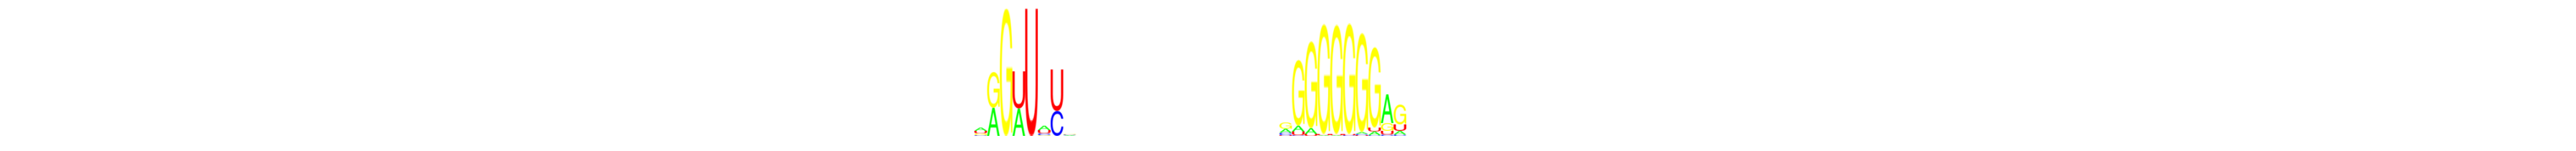

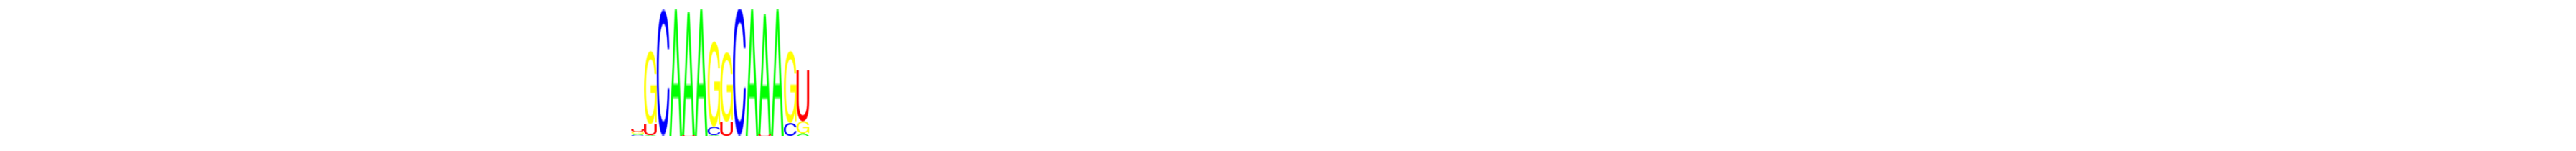

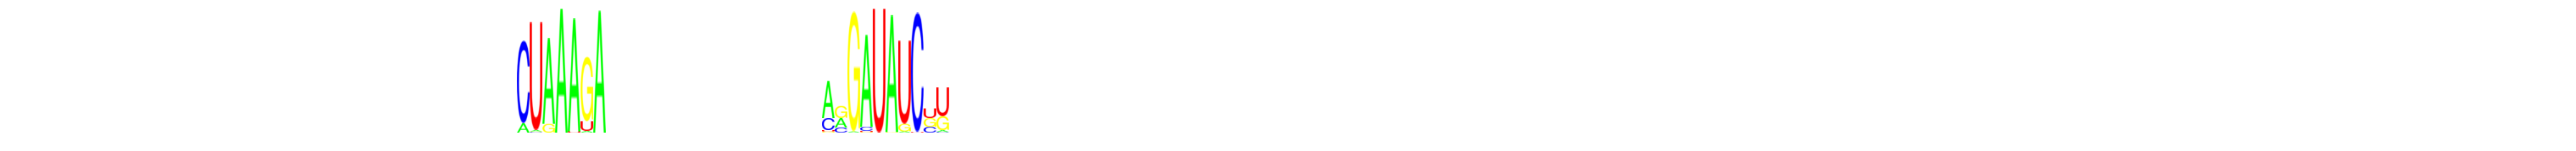

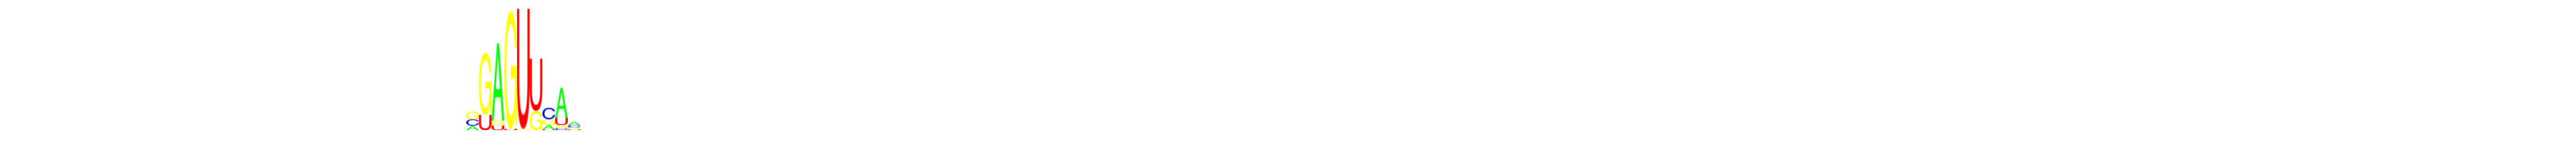

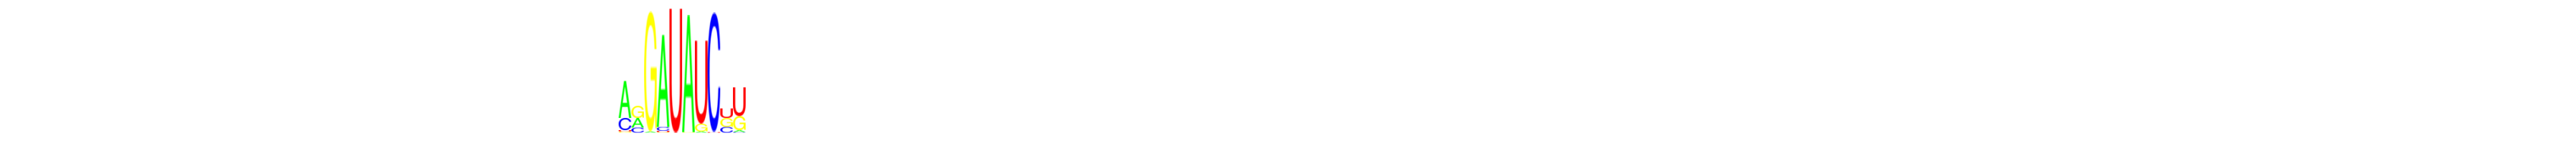

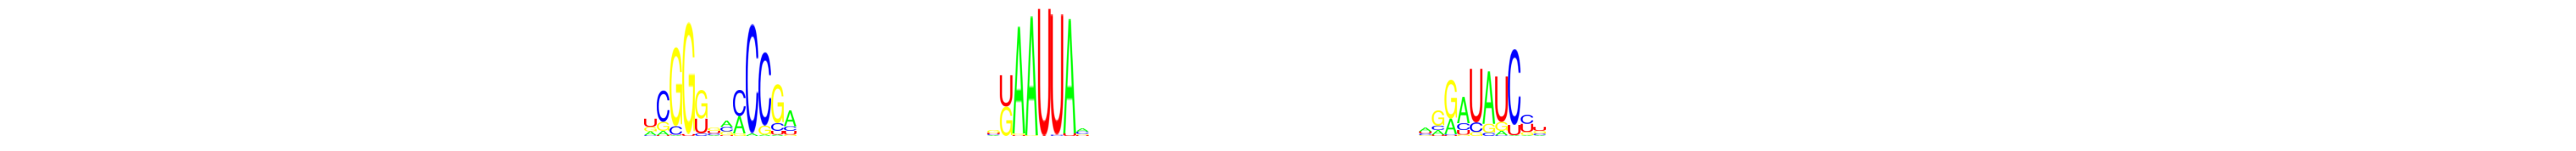

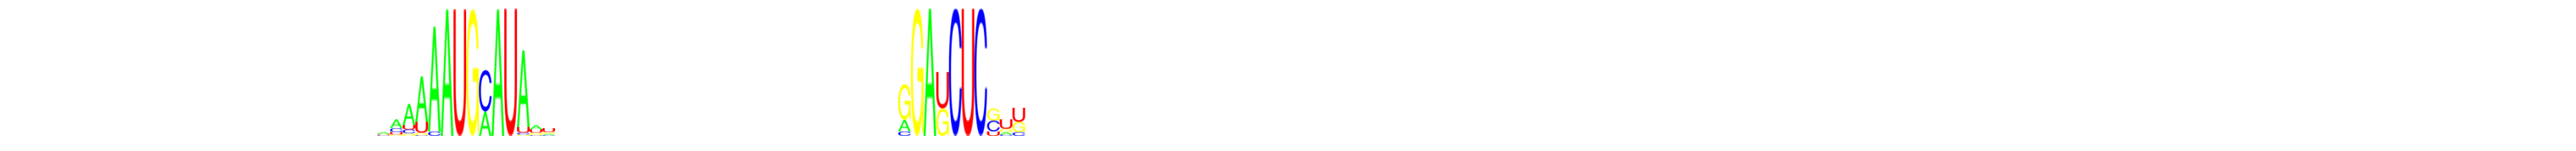

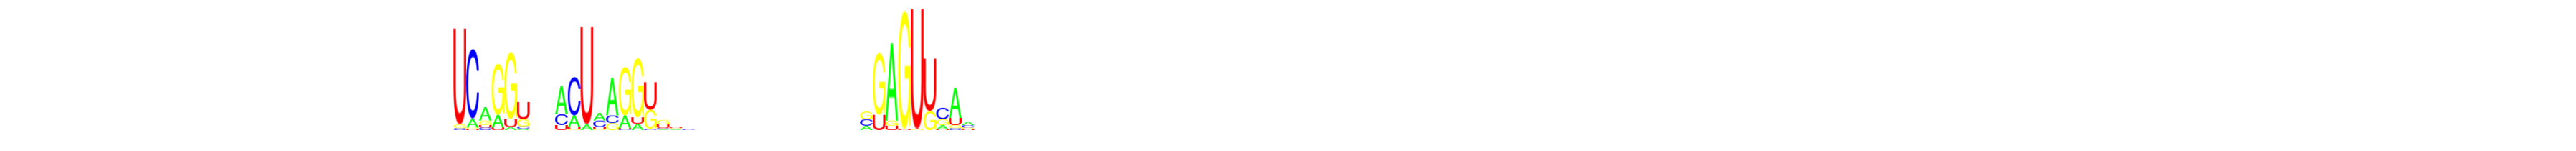

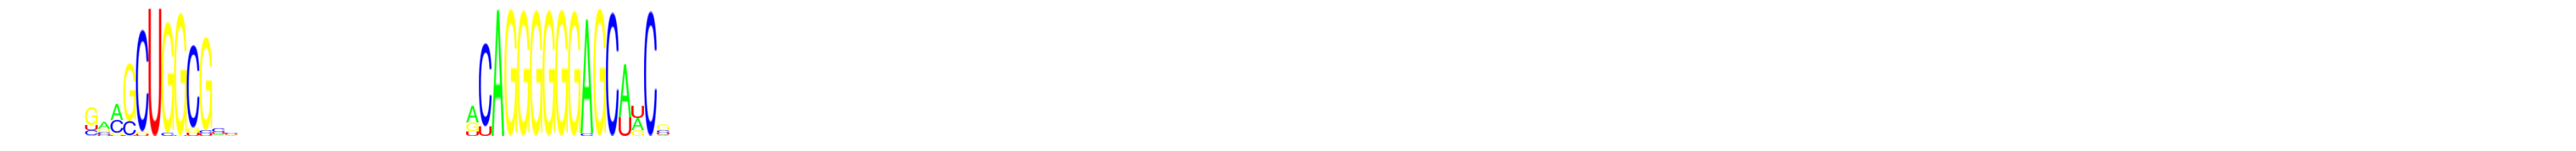

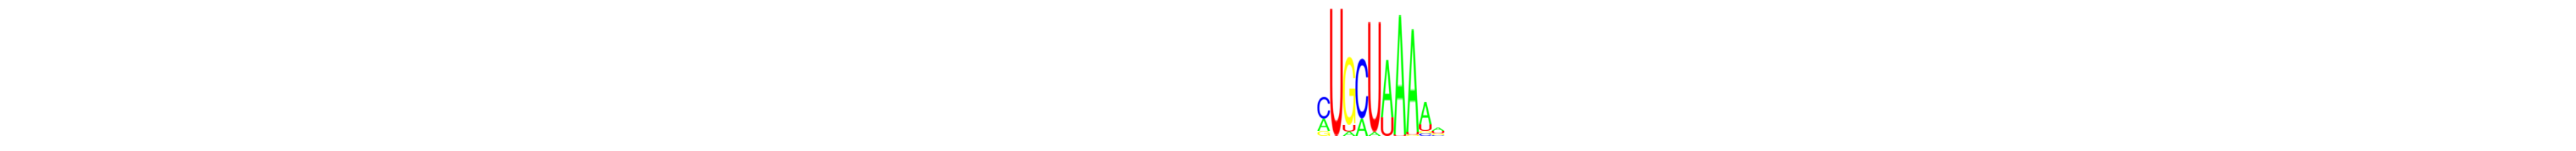

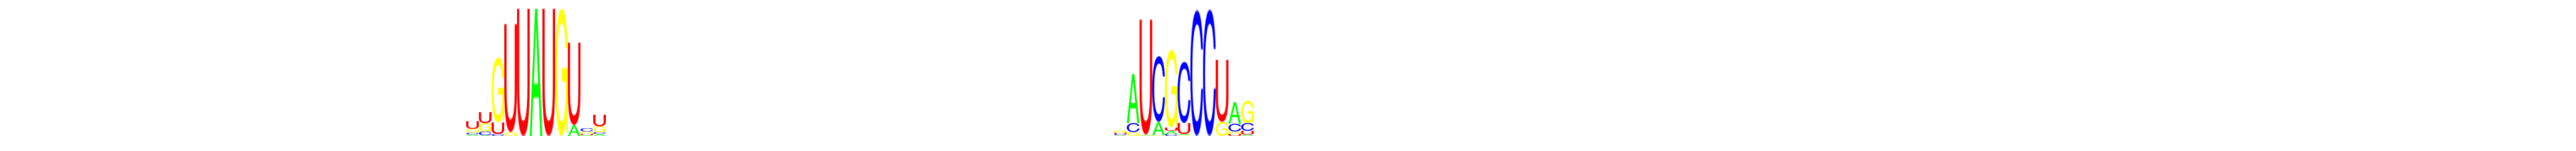

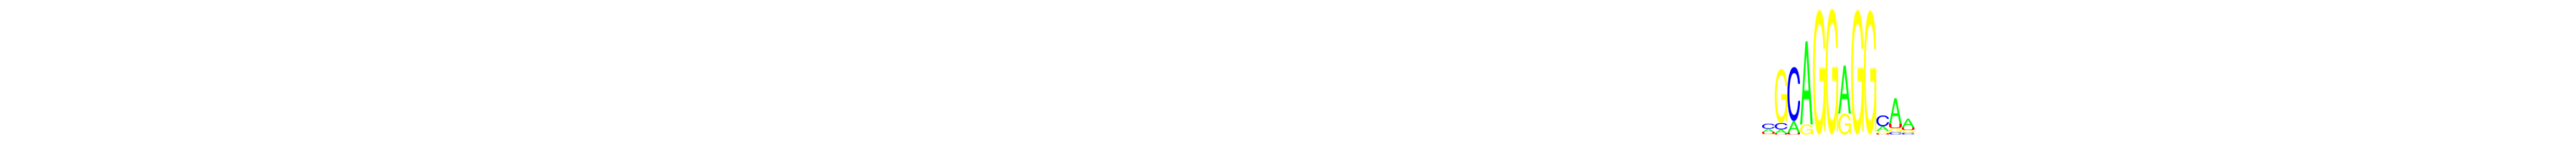

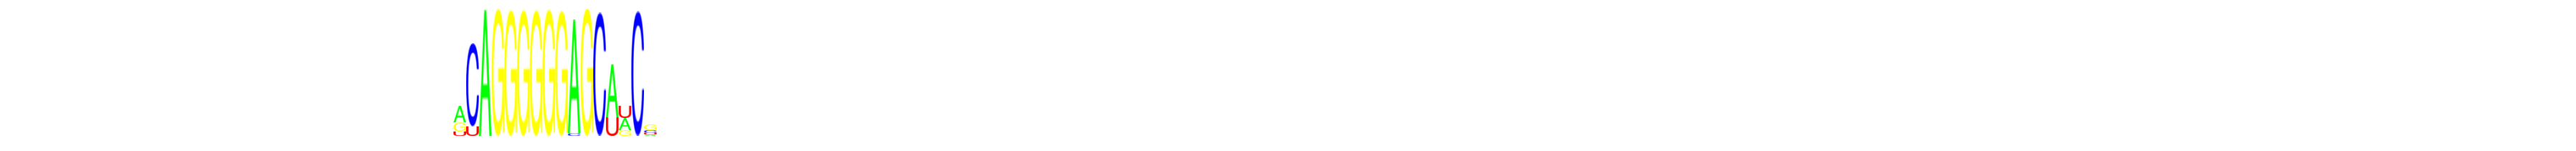

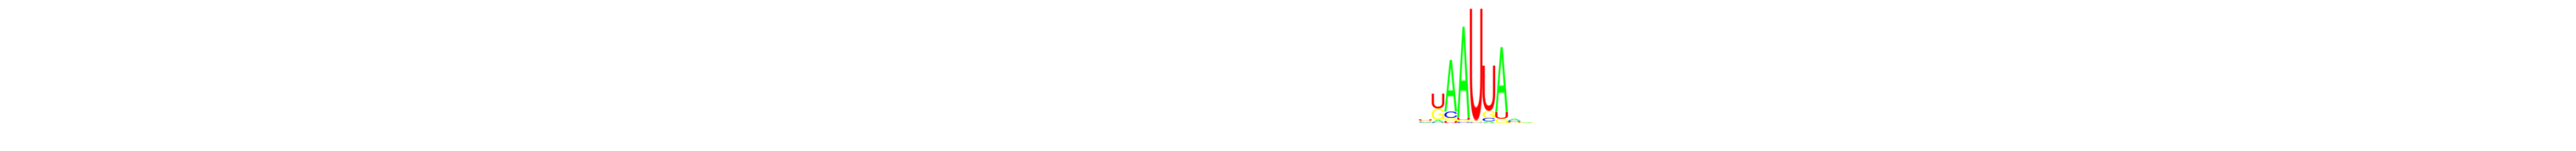

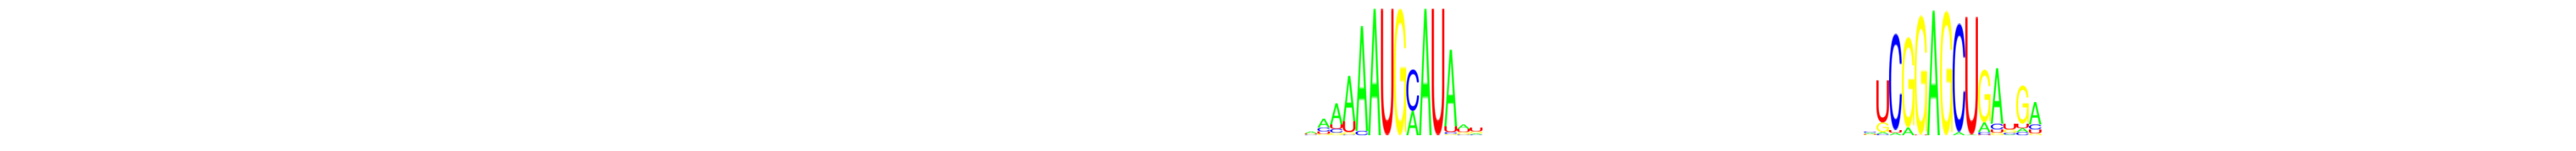

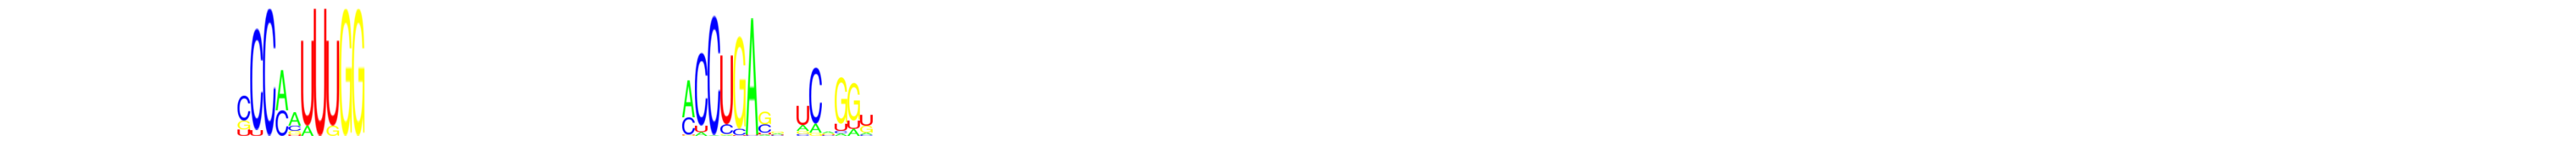

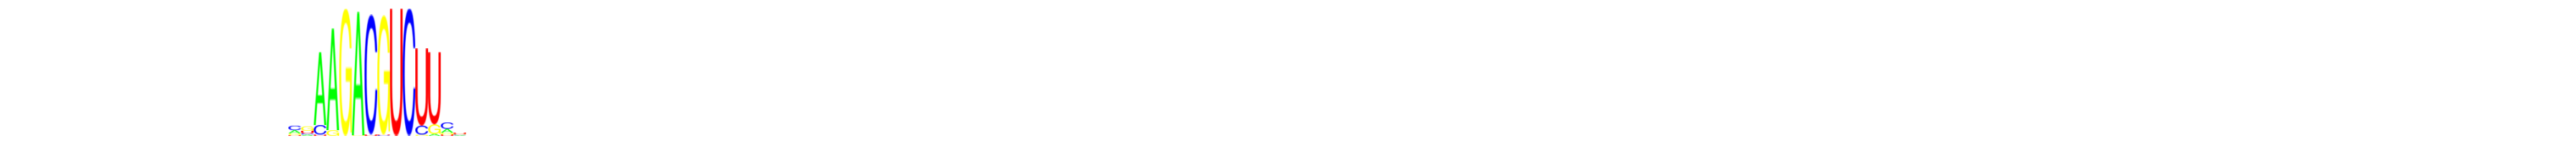

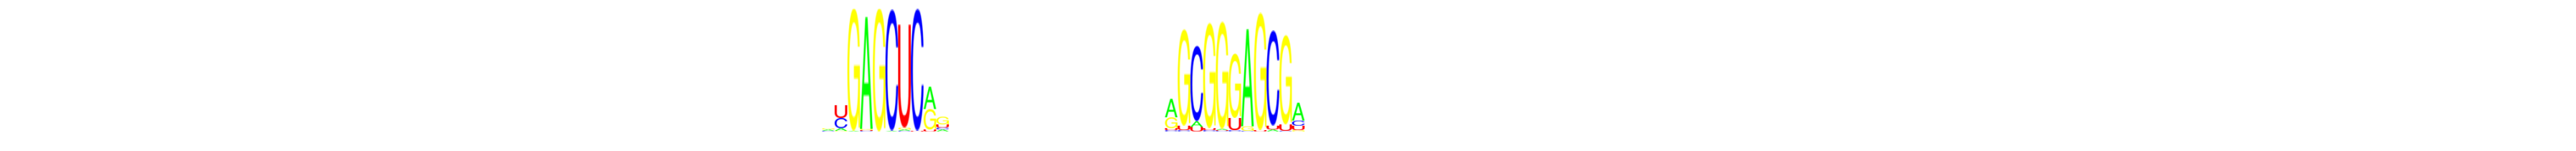

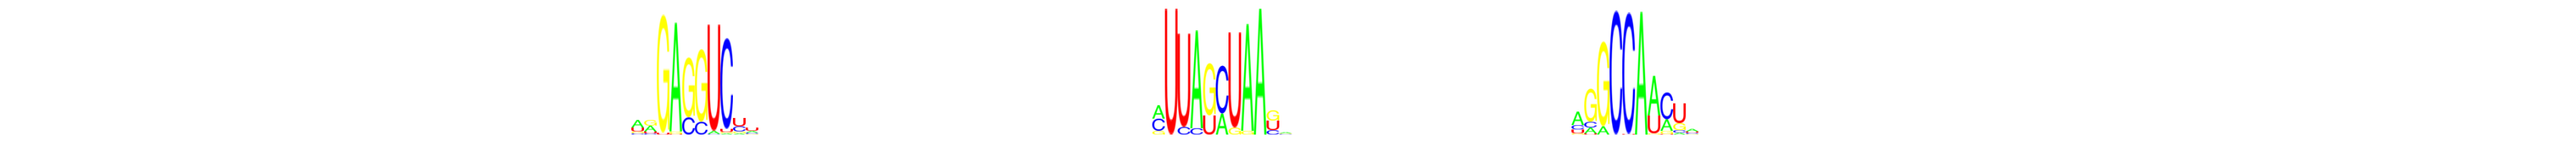

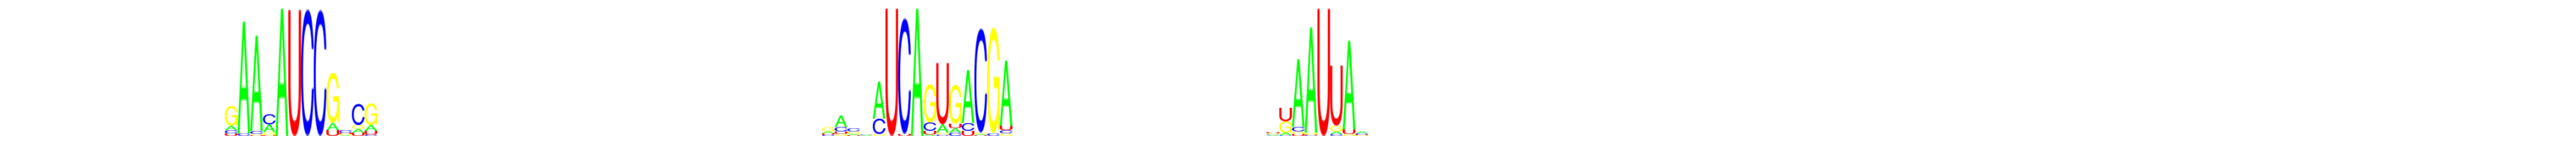

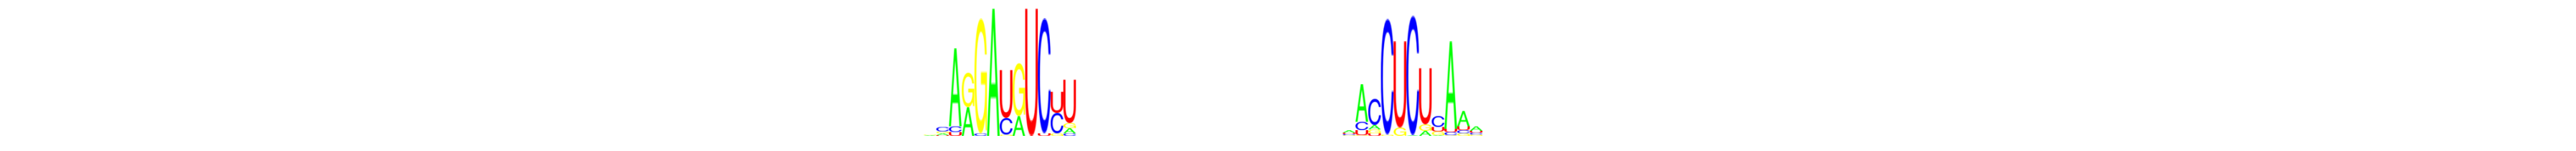

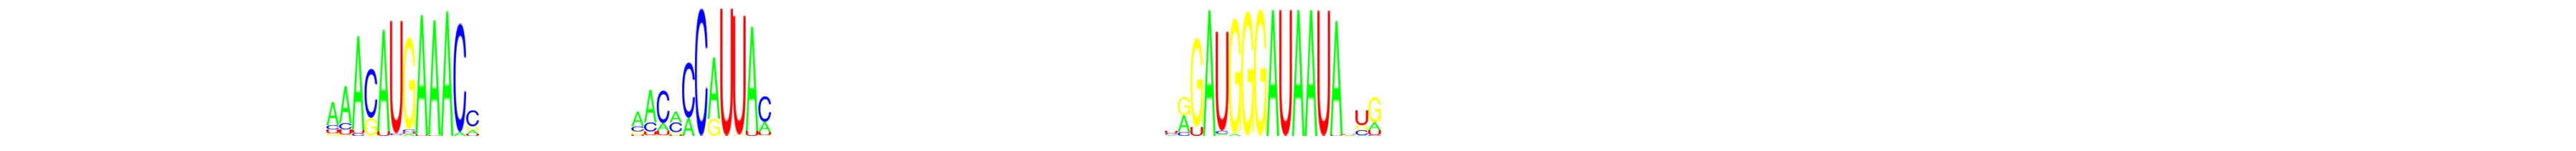

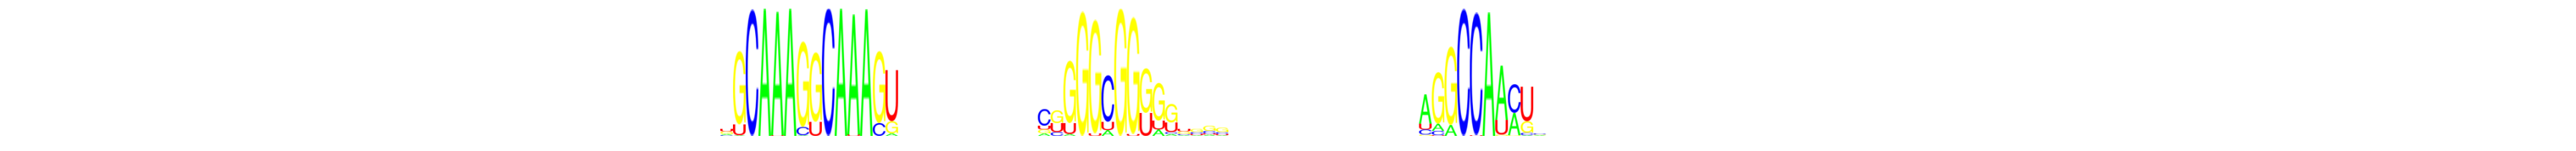

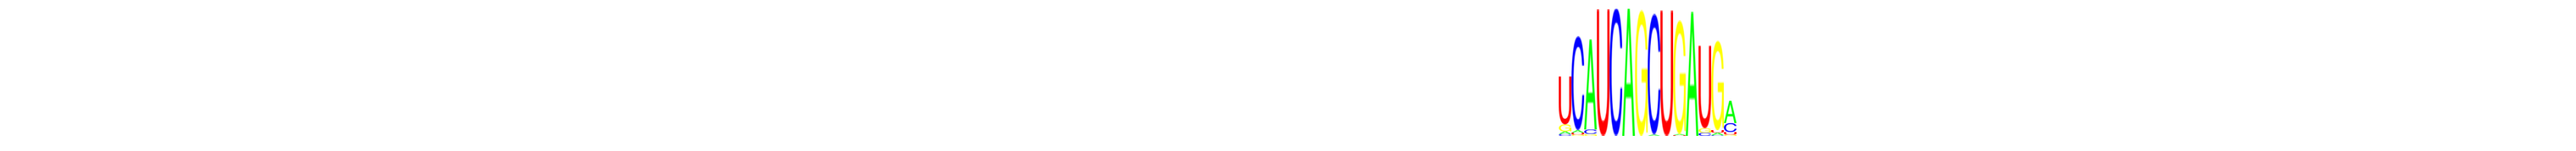

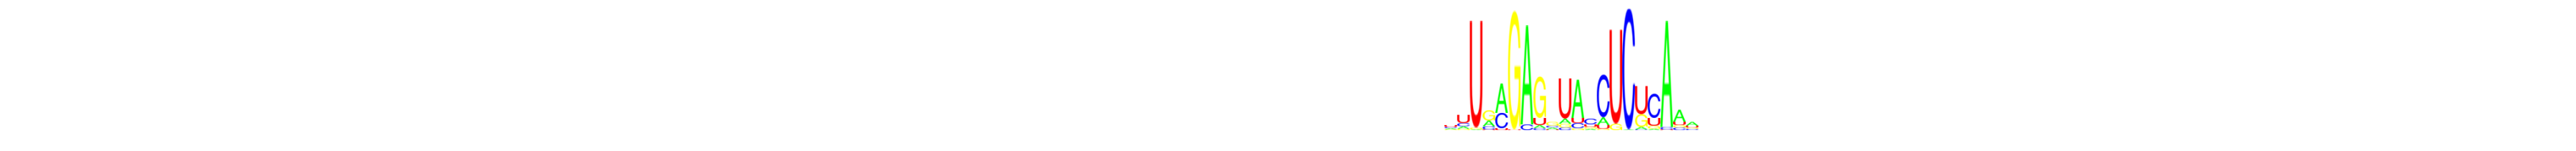

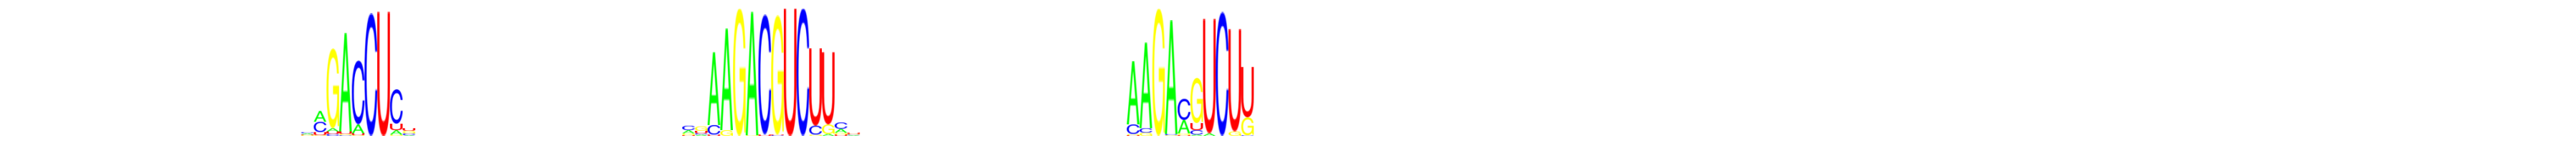

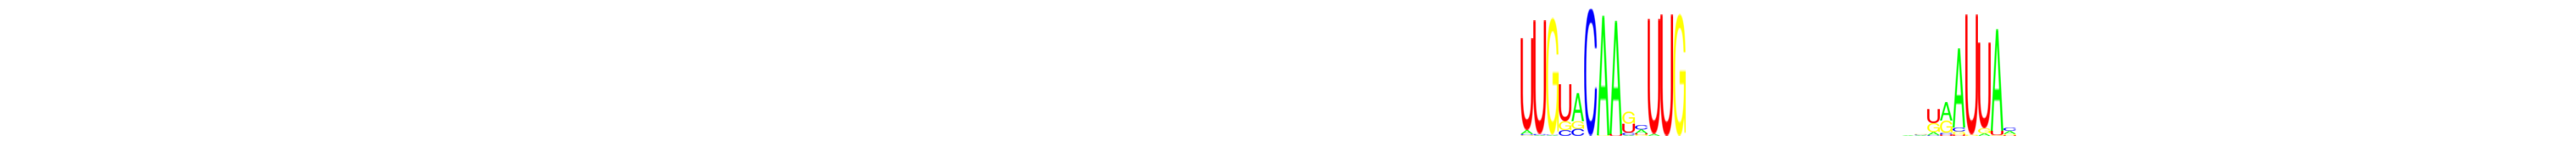

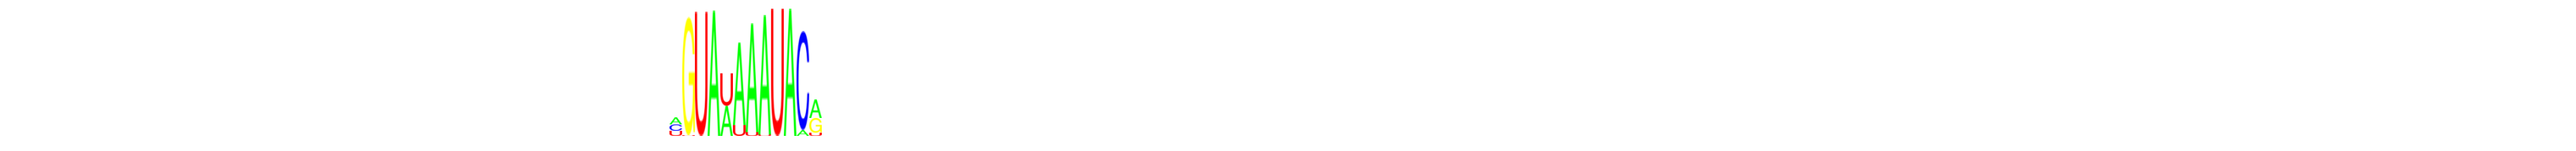

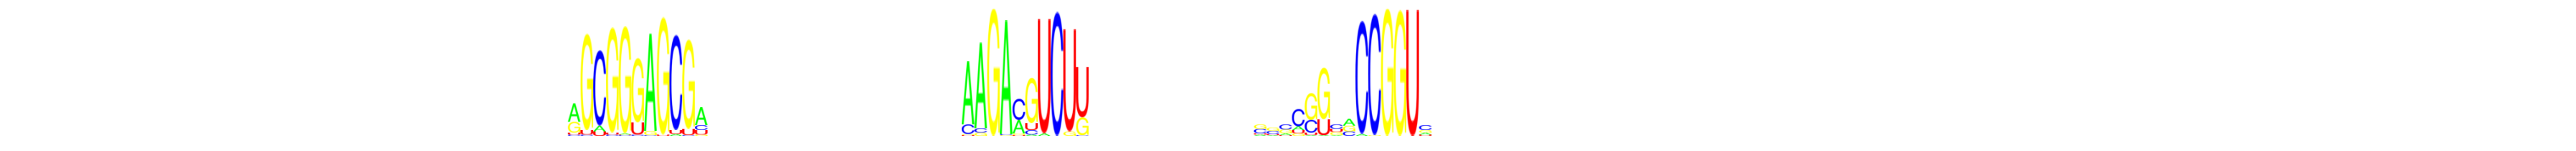

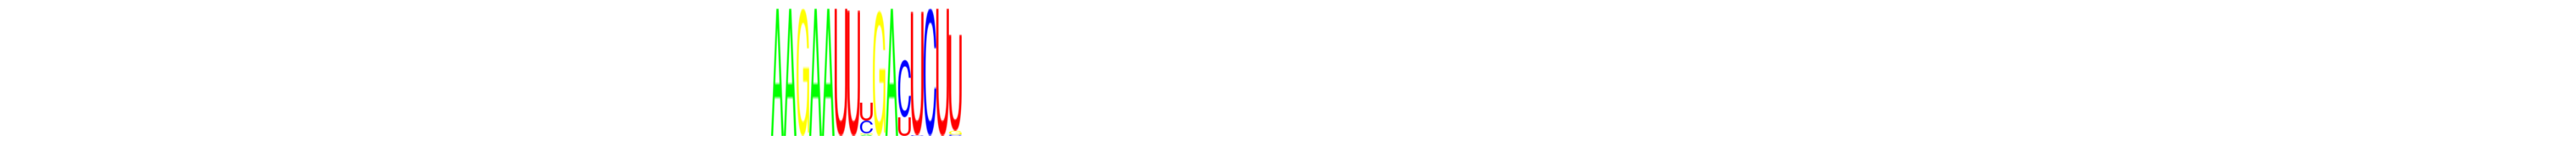

In [141]:
for i in range(30):
    pwm = seq_model[i]
    logo, heights = seq_logo(pwm, height=100, nt_width=20, norm=0, rna=0, filepath='.')
    plt.figure(figsize = (50,10))
    plt.imshow(logo)
    plt.axis('off');

In [142]:
def translate_seq_model(seq, num_samples):
    seq_length = seq.shape[1]

    # find start and end positions of implanted motifs
    max_seq = np.max(seq, axis=0)
    index = np.where(max_seq - .25 != 0)[0]
    start_bound = index[0]
    end_bound = seq_length - index[-1]
    center = (start_bound + end_bound)/2
    centroid = (float(center)/seq_length - .5)*2
    
    Z = np.sort(np.random.normal(0,1, num_samples))
    MIN = -np.min(Z)*1.4
    MAX = np.max(Z)*1.4
    neg_vals = np.round(Z[np.where(Z < centroid)[0]]*start_bound/MIN)
    pos_vals = np.round(Z[np.where(Z >= centroid)[0]]*end_bound/MAX)
    rotate = np.hstack([neg_vals, pos_vals])

    seq_rotate = []
    for r in rotate:
        shift = int(r)
        if shift > 0:
            seq_rotate.append(np.hstack([np.ones((4,np.abs(shift)))*.25, seq[:,:-np.abs(shift)]]))
        elif shift < 0:
            seq_rotate.append(np.hstack([seq[:,np.abs(shift):], np.ones((4,np.abs(shift)))*.25]))
        elif shift == 0:
            seq_rotate.append(seq)
    return seq_rotate, rotate


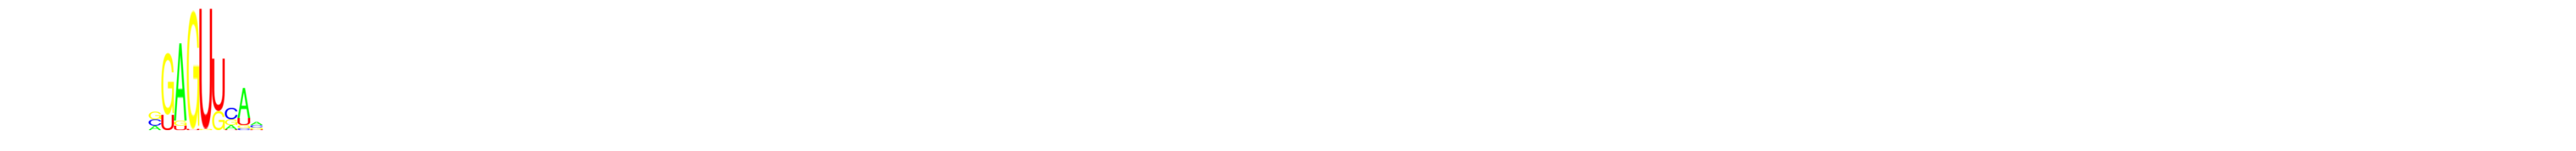

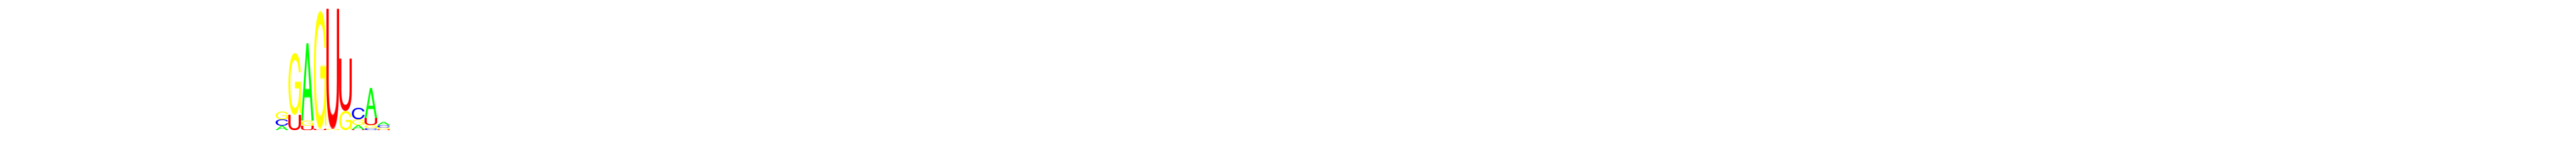

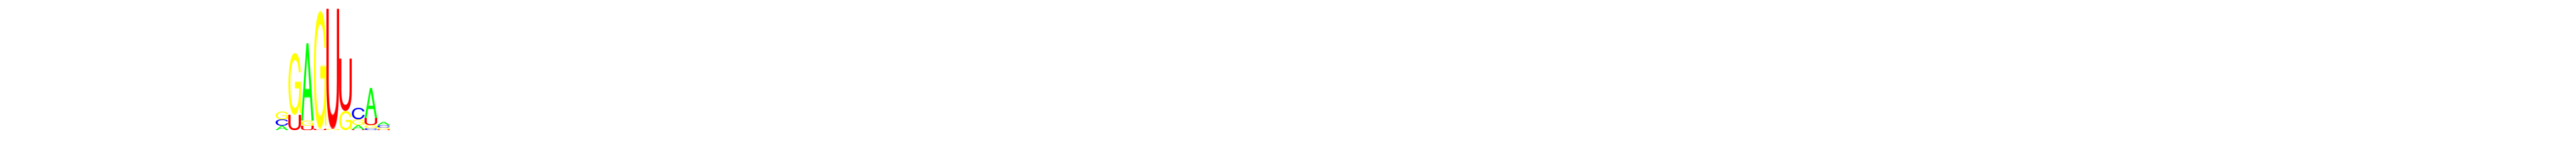

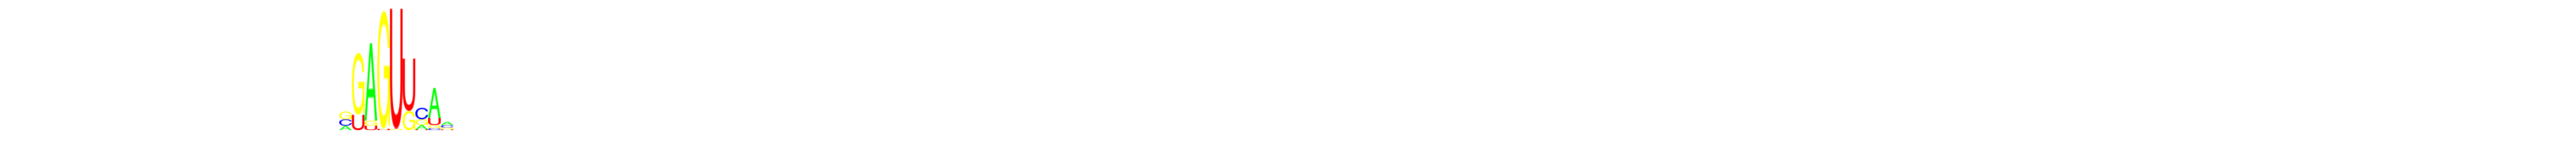

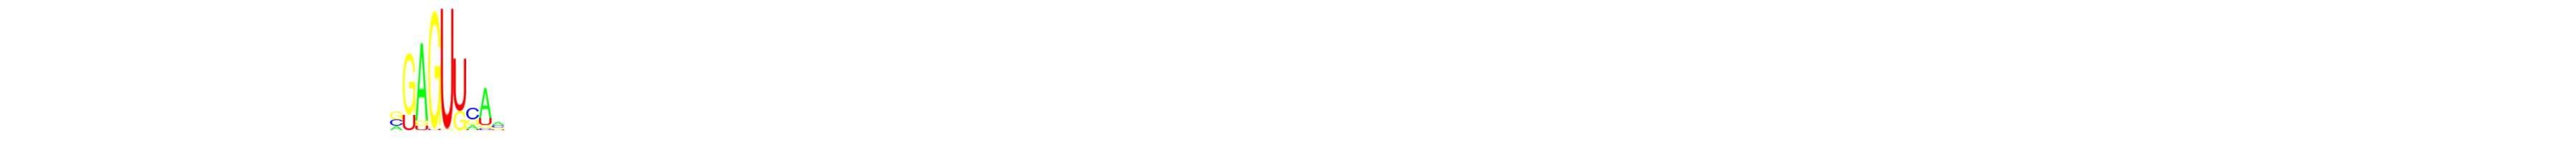

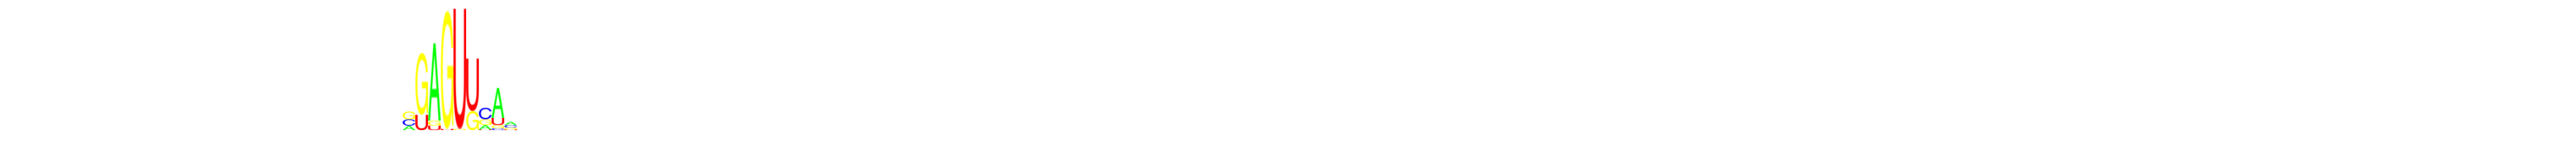

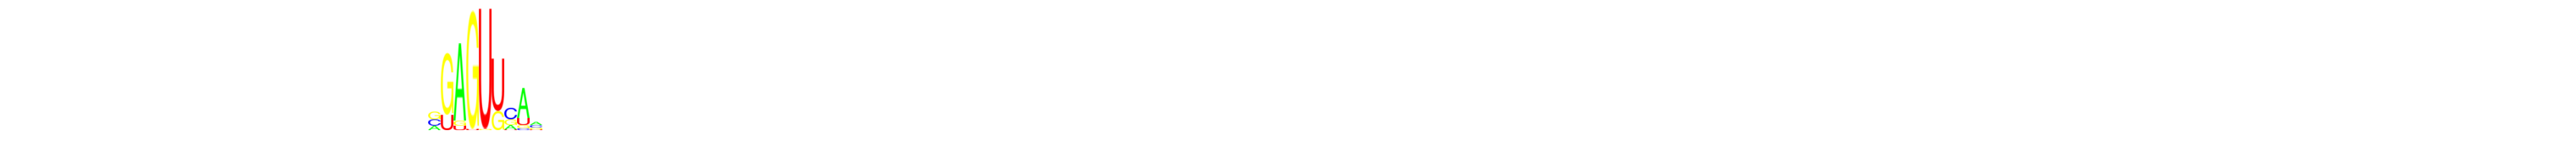

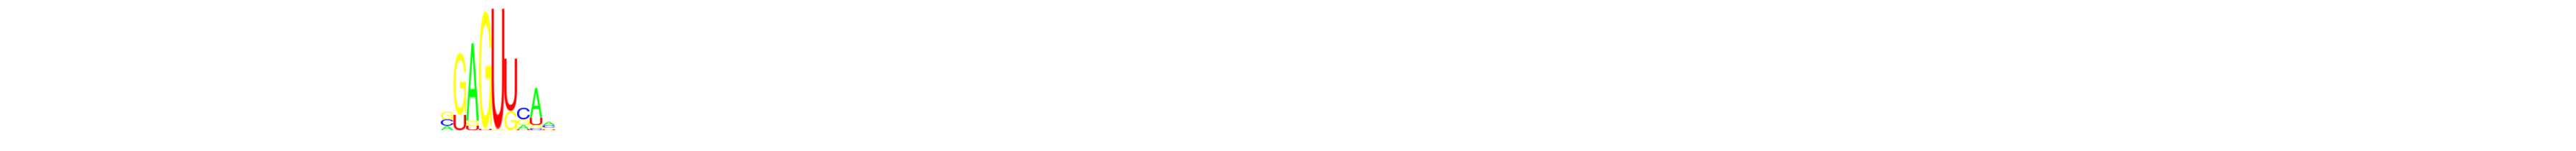

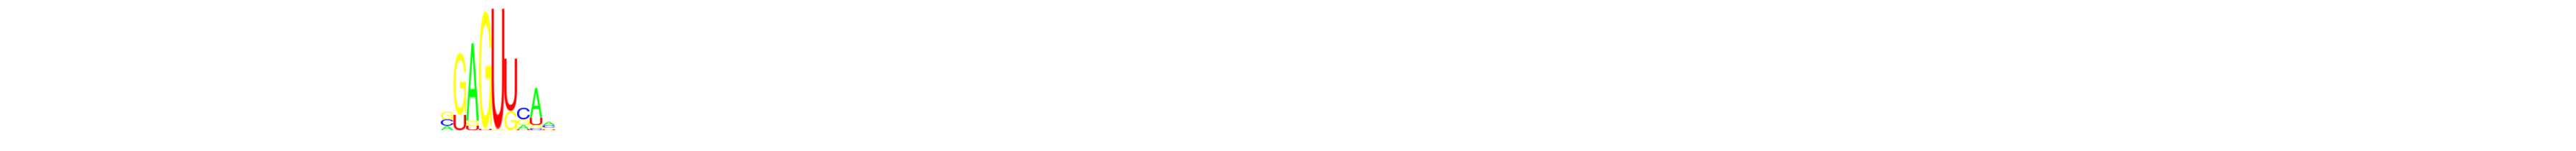

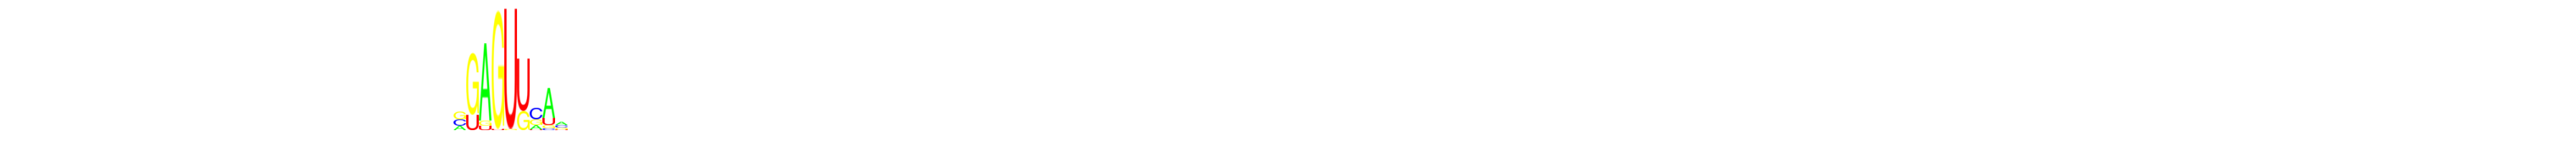

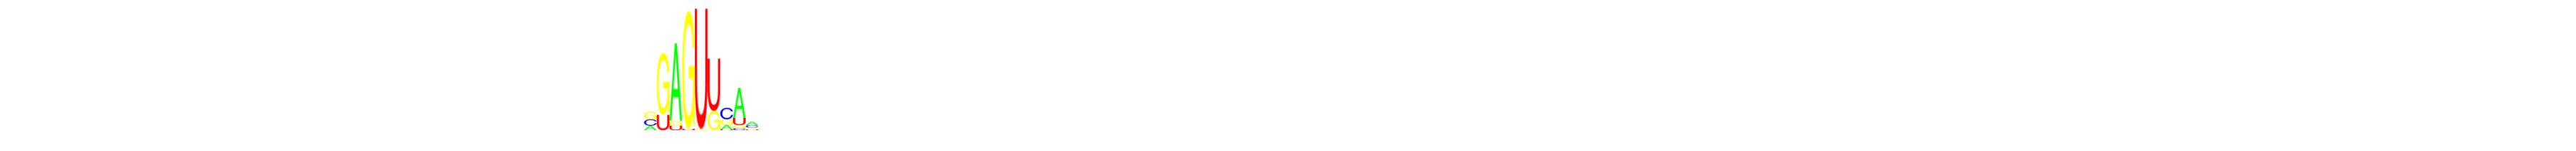

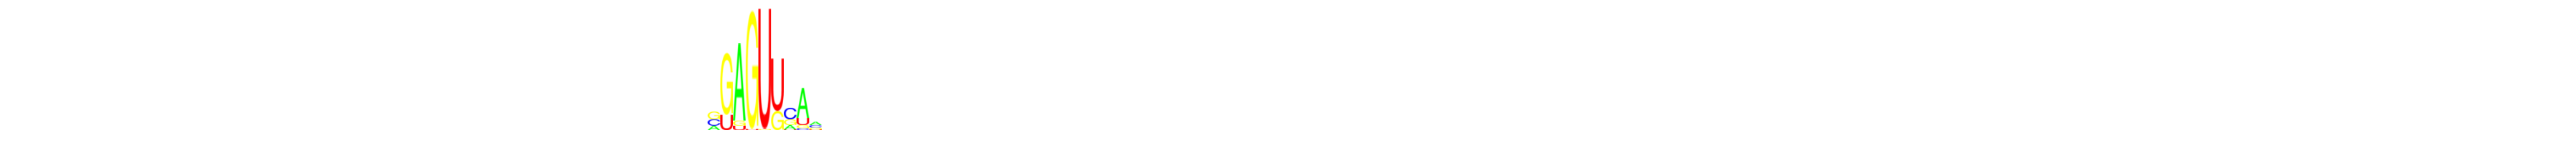

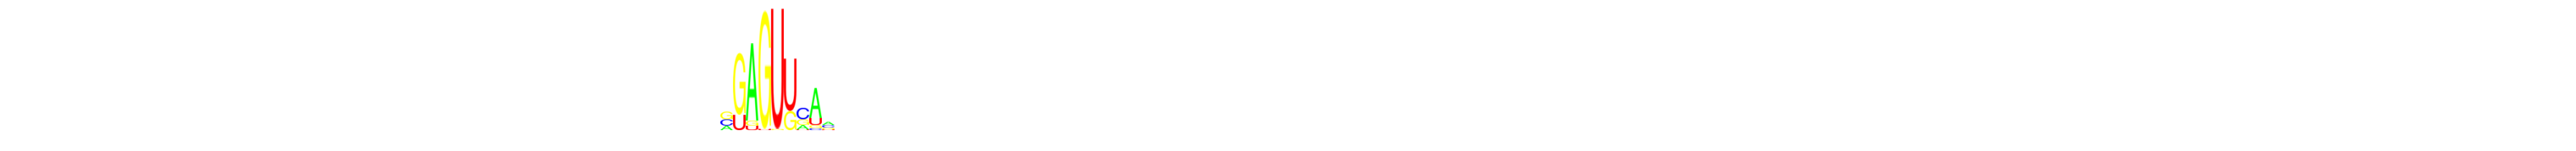

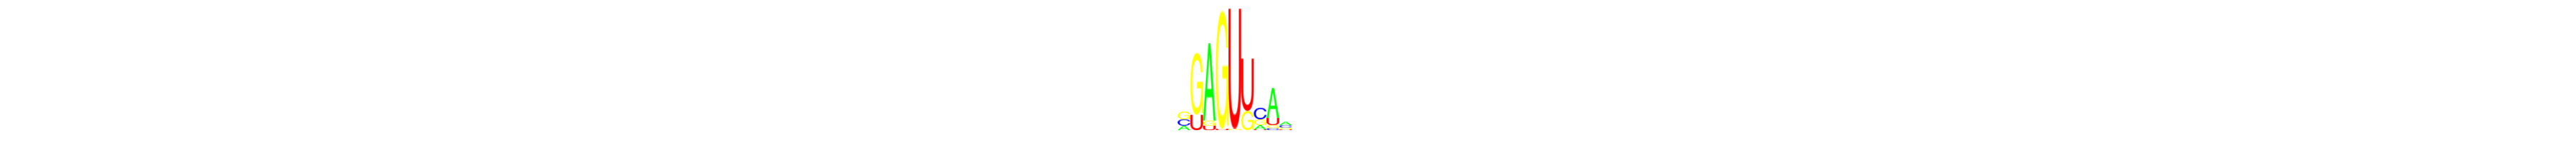

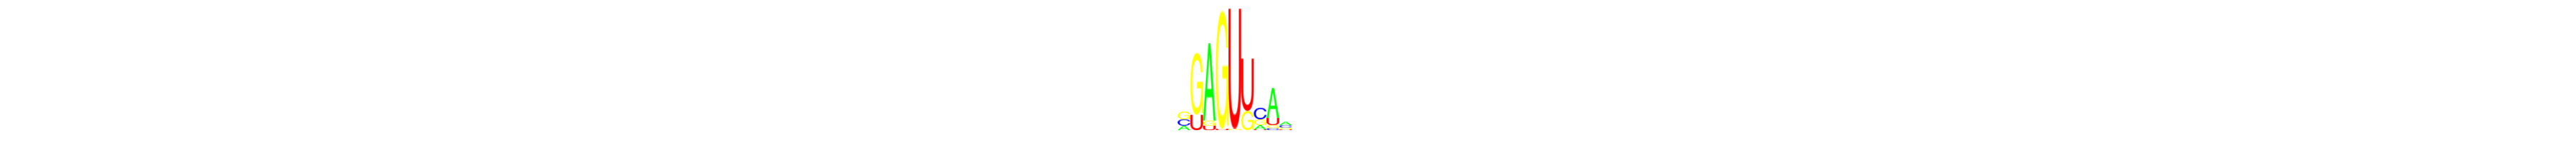

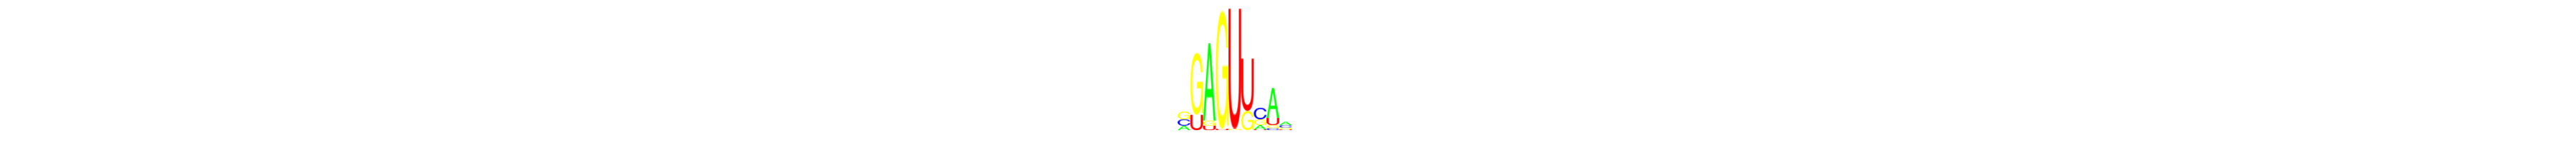

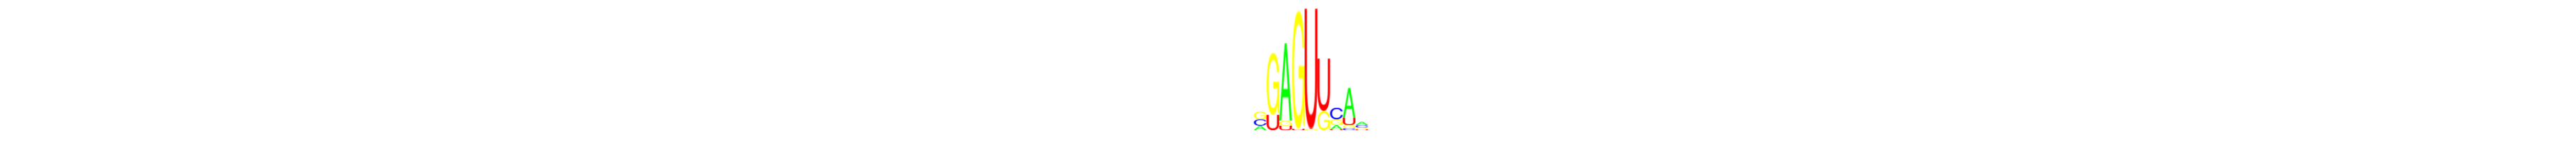

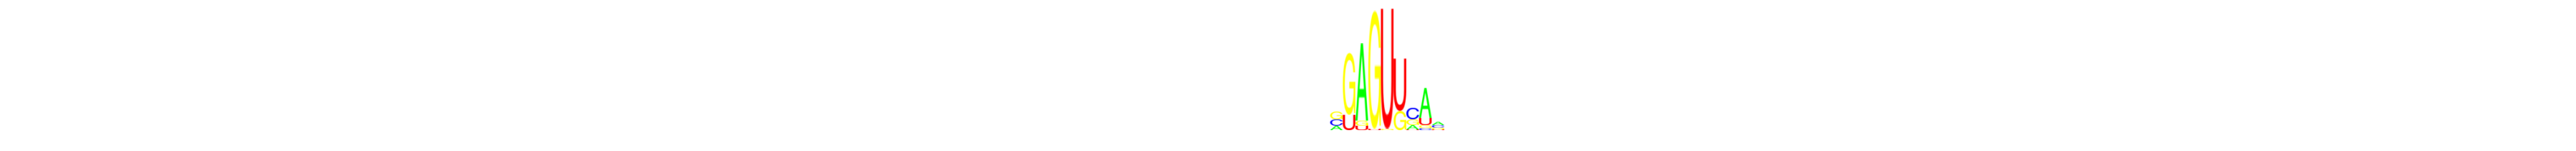

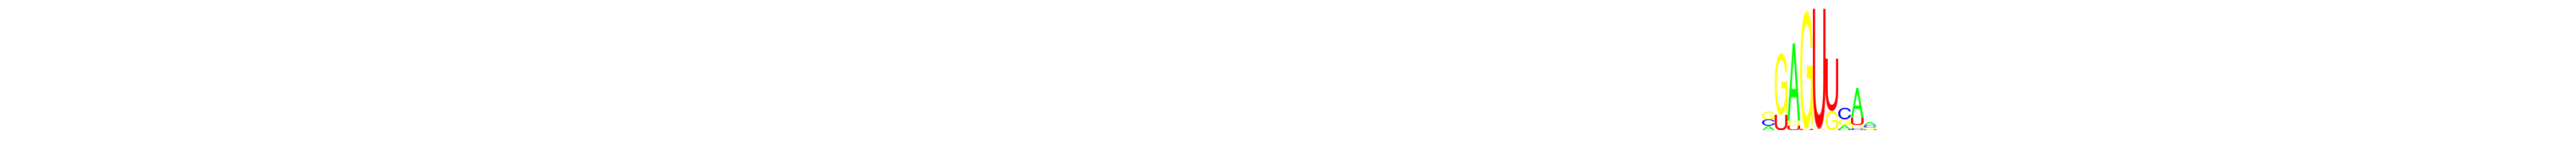

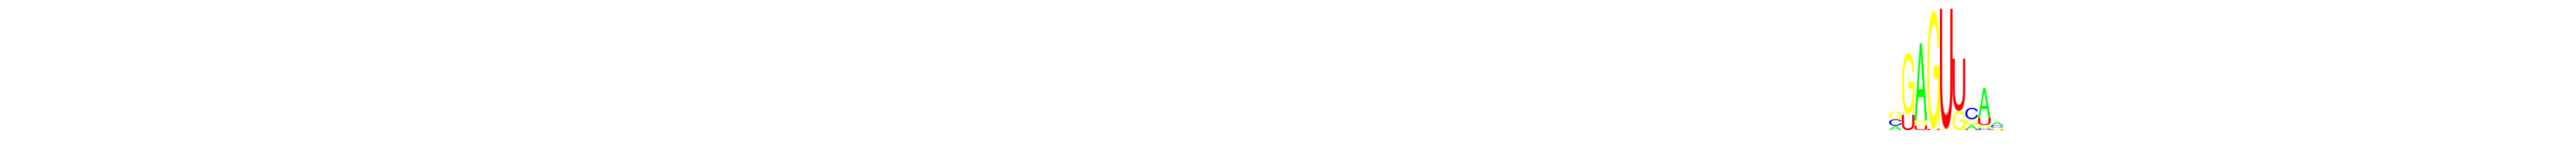

In [143]:
test, rotate = translate_seq_model(seq_model[3], num_samples=20)

for i in range(20):
    pwm = test[i]
    logo, heights = seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.')
    plt.figure(figsize = (50,10))
    plt.imshow(logo)
    plt.axis('off');
    

In [153]:
def simulate_sequence(sequence_pwm):
    """simulate a sequence given a sequence model"""
    
    nucleotide = 'ACGU'

    # sequence length
    seq_length = sequence_pwm.shape[1]

    # generate uniform random number for each nucleotide in sequence
    Z = np.random.uniform(0,1,seq_length)
    
    # calculate cumulative sum of the probabilities
    cum_prob = sequence_pwm.cumsum(axis=0)

    # go through sequence and find bin where random number falls in cumulative 
    # probabilities for each nucleotide
    sequence = ''
    for i in xrange(seq_length):
        index=[j for j in xrange(4) if Z[i] < cum_prob[j,i]][0]
        sequence += nucleotide[index]

    return sequence


def simulate_data(seq_model, num_seq, localize=1):
    """simulates N sequences with random population fractions for each sequence 
    model (PWM) of each regulatory grammar """

    # simulate random population fractions and scale to N sequences
    w = np.random.uniform(0, 1, size=len(seq_model)) + .25
    w = np.round(w/sum(w)*num_seq)
    popFrac = w.astype(int)
    print popFrac
    
    # create a popFrac weighted number of simulation for each regulatory grammar
    label = []
    data = []
    ground_truth = []
    for i in xrange(len(popFrac)):
        num_seq = popFrac[i]
        if localize == 0:
            seq, rotate = translate_seq_model(seq_model[i], popFrac[i])
            for j in xrange(popFrac[i]):
                sequence = simulate_sequence(seq[j])
                data.append(sequence)
                label.append(i)
                ground_truth.append(seq[j])
        else:
            for j in xrange(popFrac[i]):
                sequence = simulate_sequence(seq_model[i])
                data.append(sequence)
                label.append(i)
                ground_truth.append(seq_model[i])
            
    return data, label, ground_truth


def convert_one_hot(seq):
    """convert a sequence into a 1-hot representation"""
    
    nucleotide = 'ACGU'
    N = len(seq)
    one_hot_seq = np.zeros((4,N))
    for i in xrange(200):         
        #for j in range(4):
        #    if seq[i] == nucleotide[j]:
        #        one_hot_seq[j,i] = 1
        index = [j for j in xrange(4) if seq[i] == nucleotide[j]]
        one_hot_seq[index,i] = 1
        
    return one_hot_seq


def subset_data(data, label, ground_truth, sub_index):
    """returns a subset of the data and labels based on sub_index"""
    
    num_labels = len(np.unique(label))
    num_sub = len(sub_index)
    
    sub_set = np.zeros((num_sub, 4, len(data[0])))
    sub_set_label = np.zeros((num_sub, num_labels))
    sub_set_truth = []
    k = 0;
    for index in sub_index:
        sub_set[k] = convert_one_hot(data[index])
        sub_set_label[k,label[index]] = 1
        sub_set_truth.append(ground_truth[index])
        k += 1

    sub_set_label = sub_set_label.astype(np.uint8)
    
    return (sub_set, sub_set_label, sub_set_truth)


def split_data(data, label, ground_truth, split_size):
    """split data into train set, cross-validation set, and test set"""
    
    # number of labels
    num_labels = len(np.unique(label))

    # determine indices of each dataset
    N = len(data)
    cum_index = np.cumsum(np.multiply([0, split_size[0], split_size[1], split_size[2]],N)).astype(int) 

    # shuffle data
    shuffle = np.random.permutation(N)

    # training dataset
    train_index = shuffle[range(cum_index[0], cum_index[1])]
    cross_validation_index = shuffle[range(cum_index[1], cum_index[2])]
    test_index = shuffle[range(cum_index[2], cum_index[3])]

    # create subsets of data based on indices 
    train = subset_data(data, label, ground_truth, train_index)
    cross_validation = subset_data(data, label, ground_truth, cross_validation_index)
    test = subset_data(data, label, ground_truth, test_index)
    
    return train, cross_validation, test





In [155]:

num_seq = 300000       # number of sequences

# simulate N sequences based on the position weight matrices
print "Generating synthetic data"
data, label, ground_truth = simulate_data(seq_model, num_seq, localize=1)

# get indices for each dataset
print "Splitting dataset into train, cross-validation, and test"
split_size = [train_size, cross_validation_size, test_size]
train, cross_validation, test = split_data(data, label, ground_truth, split_size)


filename =  'Localized_N=' + str(num_seq) + \
            '_S=' + str(seq_length) + \
            '_M=' + str(num_motif) + \
            '_G=' + str(num_grammar) # output filename
            
# save training dataset in one-hot representation
print "Saving dataset"
f = open(filename+'_data.pickle', 'wb')
cPickle.dump(train, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(cross_validation, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(test, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

# save training dataset in one-hot representation
print "Saving model"
f = open(filename+'_model.pickle', 'wb')
cPickle.dump(options, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(model, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(seq_model, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(ground_truth, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()


Generating synthetic data
[13248  8739 13497 13113 14128  9526  5118 12044  8392  6599  8087 12932
 13259 12334  6345 15188  7248 10347  8680 13991 12007  5128  3844  3454
 11851 14236 12107  7864 10928  5766]


KeyboardInterrupt: 

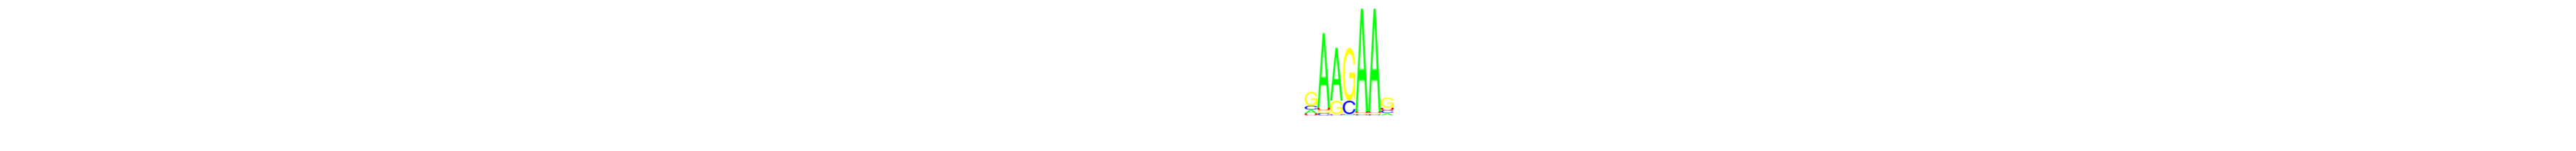

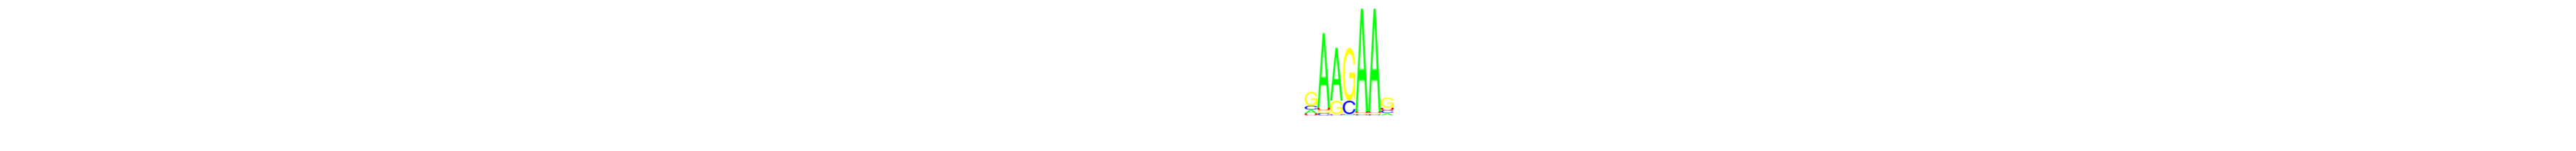

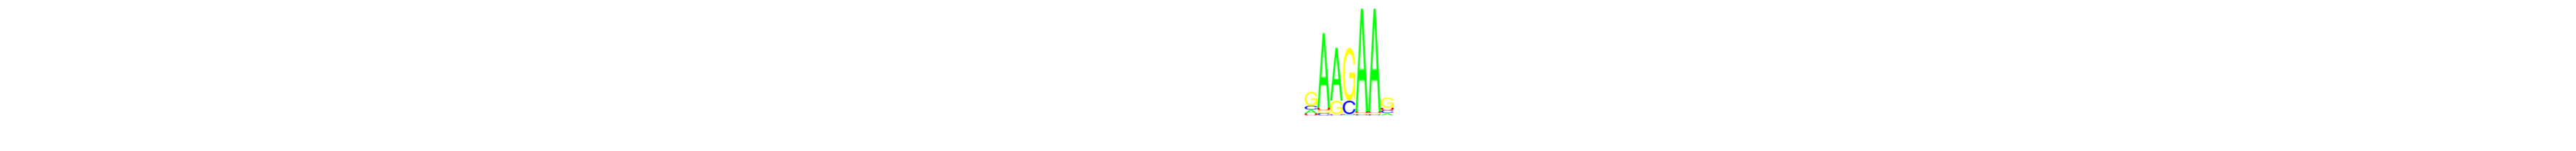

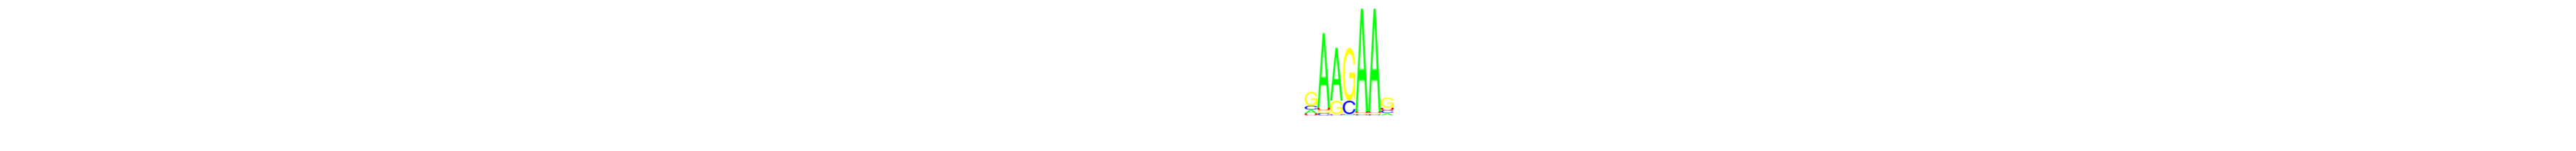

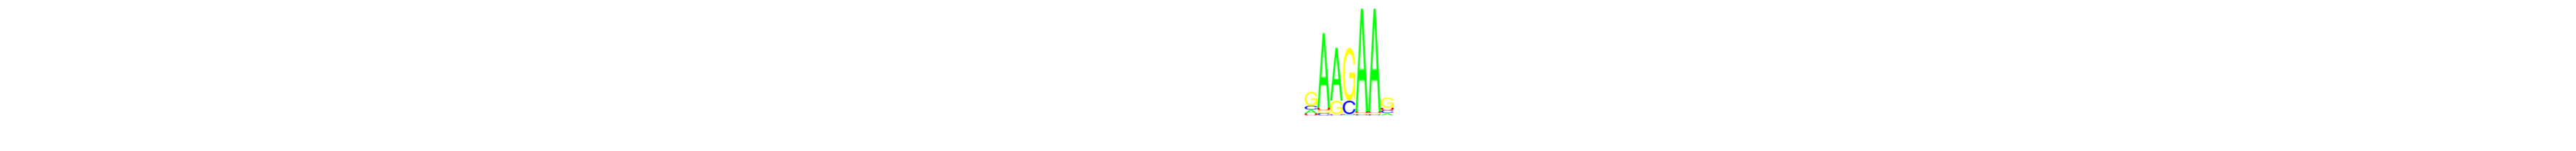

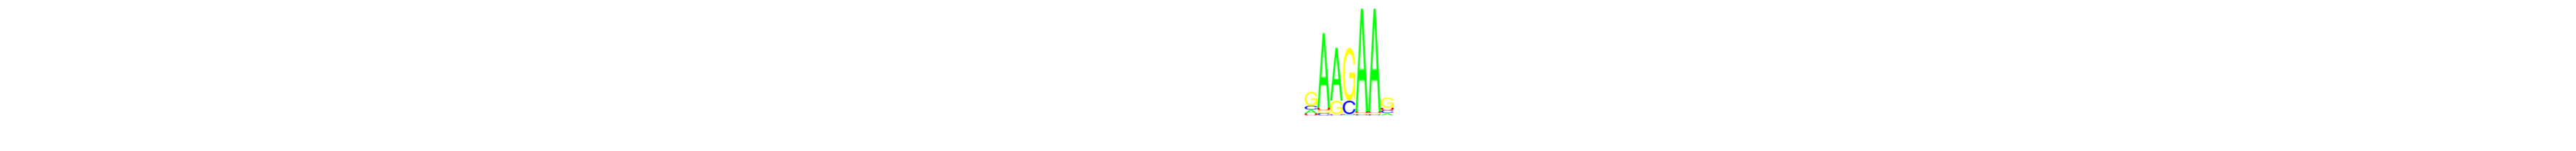

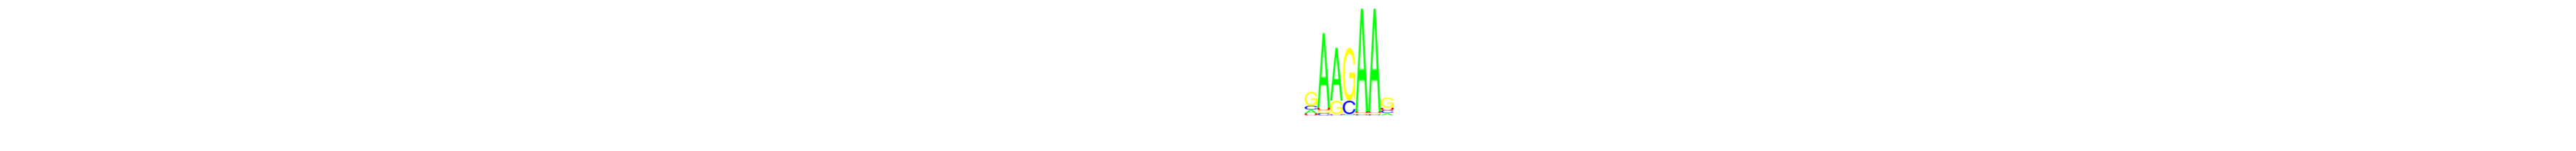

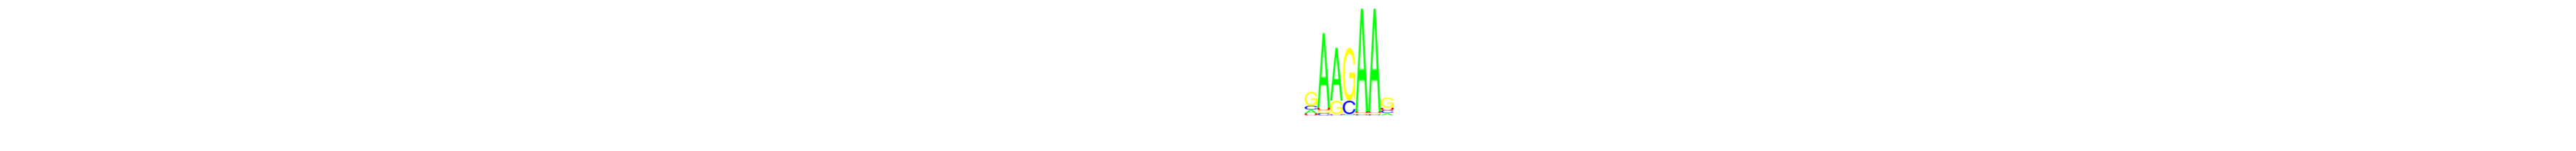

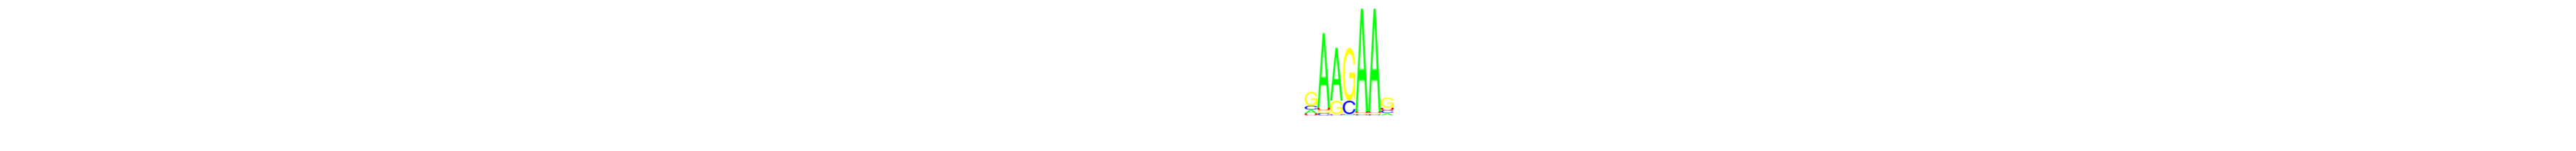

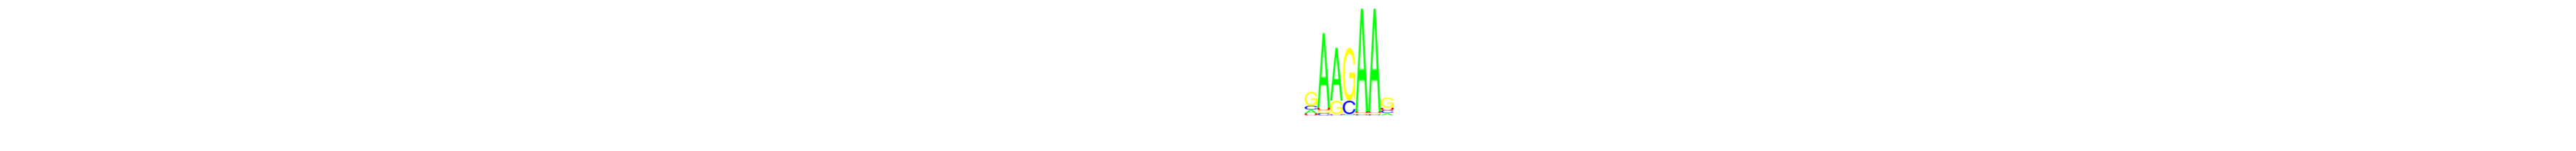

In [88]:
class_index = 17

labels = np.argmax(test[1],axis=1)
map_index = np.where(labels == class_index)[0]
for index in map_index[:10]:
    
    pwm = test[2][index]
    logo, heights = seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.')
    plt.figure(figsize = (50,10))
    plt.imshow(logo)
    plt.axis('off');

In [146]:


# simulate N sequences based on the position weight matrices
print "Generating synthetic data"
data, label, ground_truth = simulate_data(seq_model, num_seq, localize=0)


Generating synthetic data
[2144 1268 4067 4060 2419 3555 4595 3575 4583 4363 3492 3352 2357 3175 1706
 4681 3278 4194 2372 2470 1530 4444 3955 3743 3229 2264 4490 3383 2233 5020]


In [147]:

# get indices for each dataset
print "Splitting dataset into train, cross-validation, and test"
split_size = [train_size, cross_validation_size, test_size]
train, cross_validation, test = split_data(data, label, ground_truth, split_size)

Splitting dataset into train, cross-validation, and test


In [148]:


filename =  'Unlocalized_N=' + str(num_seq) + \
            '_S=' + str(seq_length) + \
            '_M=' + str(num_motif) + \
            '_G=' + str(num_grammar) # output filename
            
# save training dataset in one-hot representation
print "Saving dataset"
f = open(filename+'_data.pickle', 'wb')
cPickle.dump(train, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(cross_validation, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(test, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

# save training dataset in one-hot representation
print "Saving model"
f = open(filename+'_model.pickle', 'wb')
cPickle.dump(options, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(model, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(seq_model, f, protocol=cPickle.HIGHEST_PROTOCOL)
cPickle.dump(ground_truth, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()


Saving dataset
Saving model


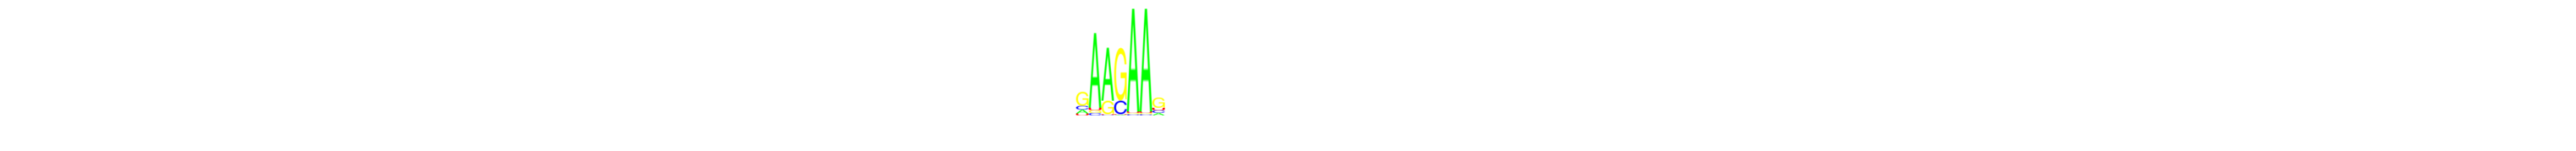

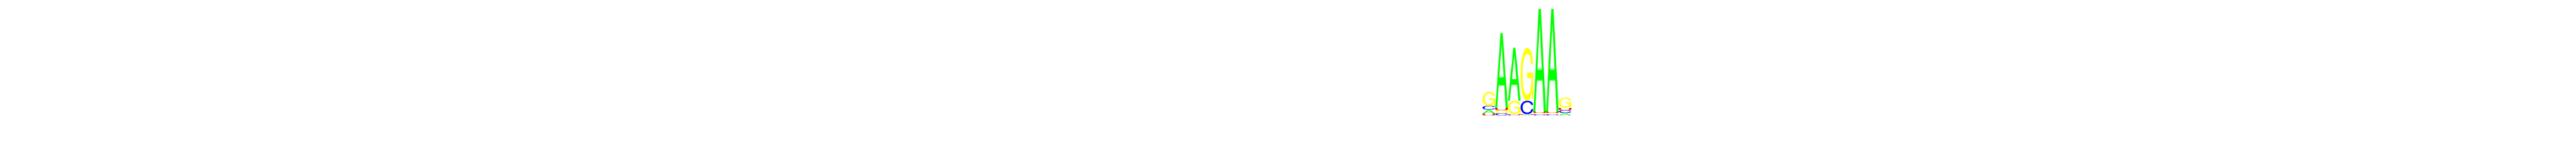

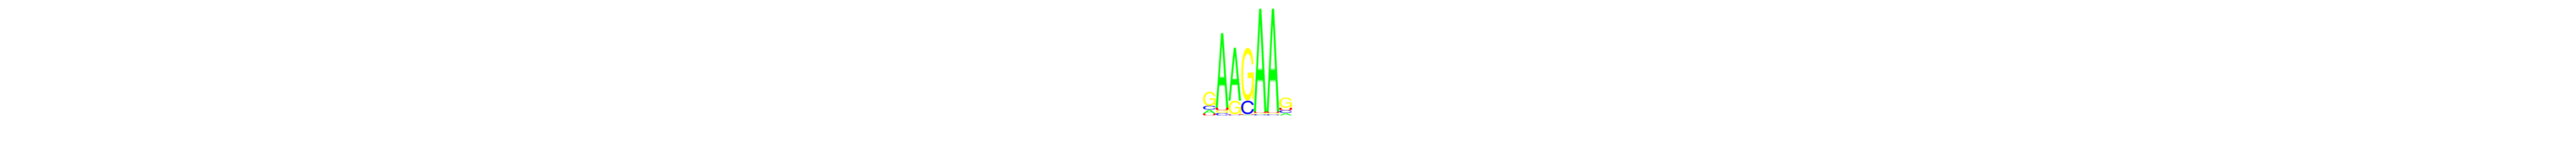

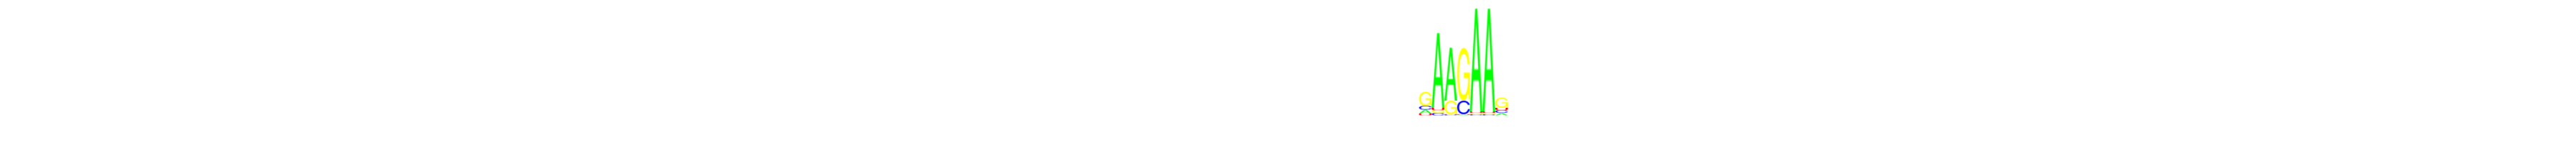

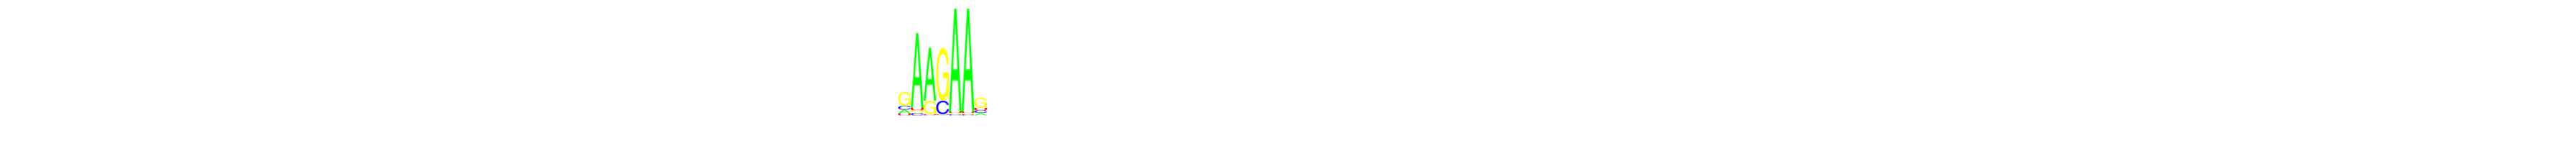

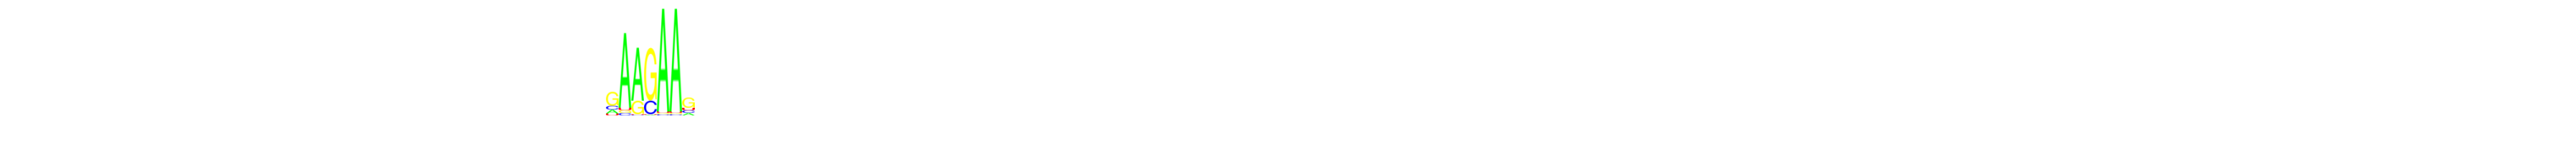

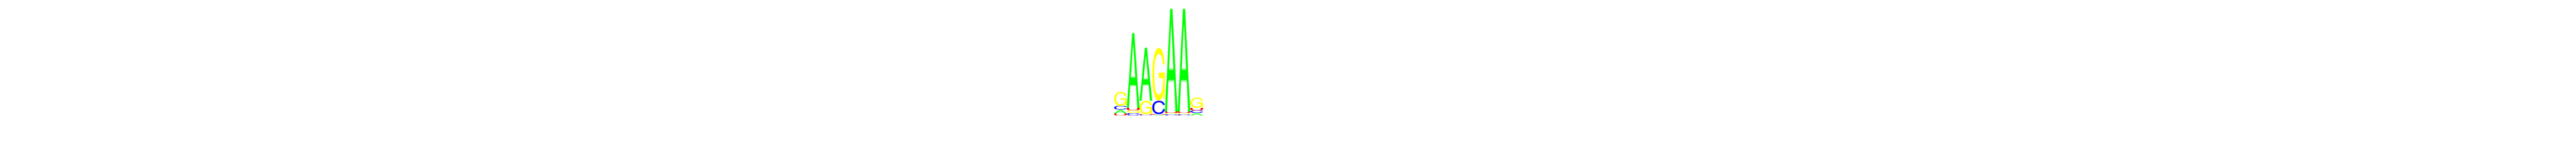

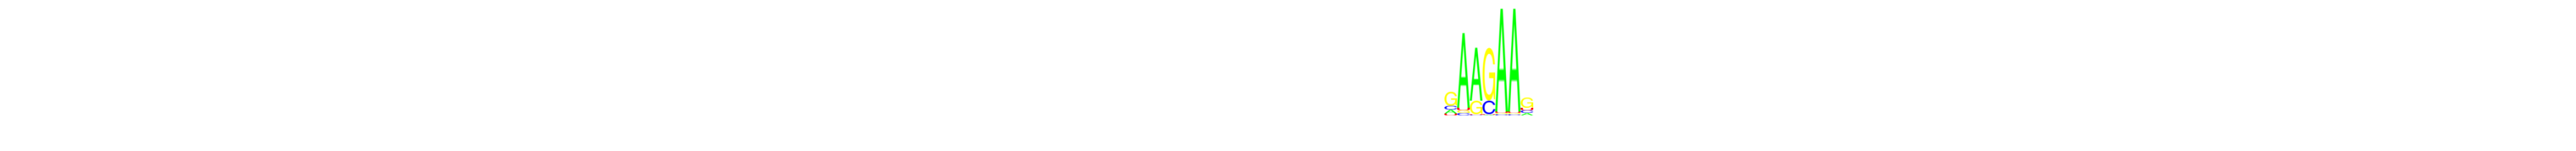

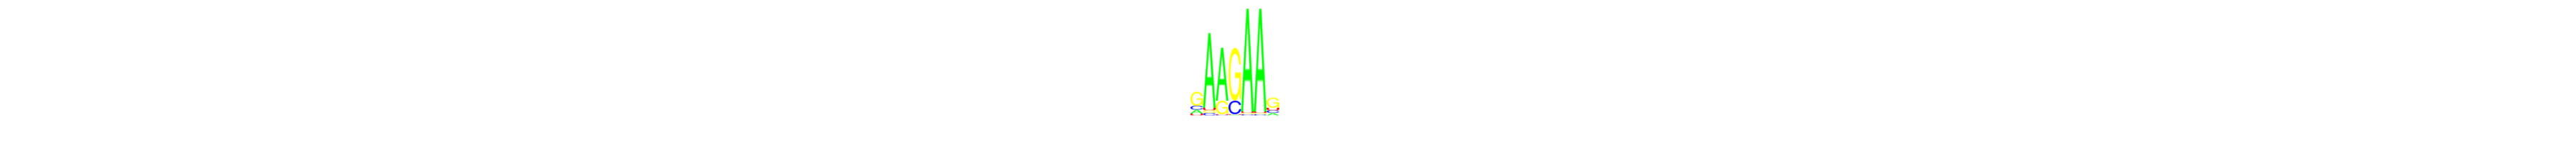

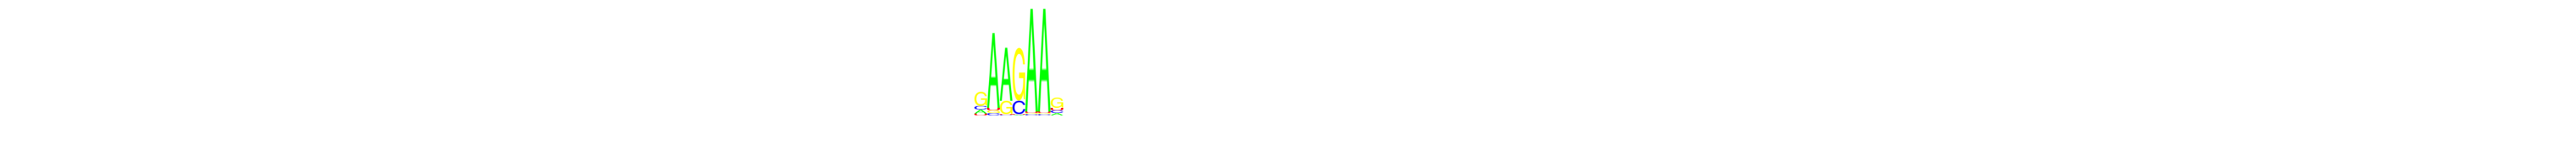

In [92]:
class_index = 17

labels = np.argmax(test[1],axis=1)
map_index = np.where(labels == class_index)[0]
for index in map_index[:10]:
    
    pwm = test[2][index]
    logo, heights = seq_logo(pwm, height=100, nt_width=20, norm=0, rna=1, filepath='.')
    plt.figure(figsize = (50,10))
    plt.imshow(logo)
    plt.axis('off');
    